# Support Vector Machines

## Loading train/test parquet from S3

In [1]:
import pandas as pd

path_train = "s3://crisk-nico-prod/curated/apps_merged_bureau_agg_1/"
path_test = "s3://crisk-nico-prod/curated/apps_merged_bureau_agg_test/"

df_train = pd.read_parquet(path_train, storage_options={"anon": False})
df_test = pd.read_parquet(path_test, storage_options={"anon": False})


## General information about data

* Glue ETL already standardized missingness & types
* Test set separation ensures unbiased evaluation
* dataset has 112 features and 1 binary label

In [2]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 113 entries, SK_ID_CURR to bucket_id
dtypes: category(1), float64(49), int64(51), object(12)
memory usage: 263.1+ MB


In [3]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 112 entries, SK_ID_CURR to bucket_id
dtypes: category(1), float64(49), int64(50), object(12)
memory usage: 41.3+ MB


## Splitting features and target

* `SK_ID_CURR` = identifier
* `bucket_id` = technical partition

In [4]:
Xtrain = df_train.drop(["SK_ID_CURR", "TARGET", "bucket_id"], axis=1)
ytrain = df_train["TARGET"]

Xtest = df_test.drop(["SK_ID_CURR", "bucket_id"], axis=1)

## Detect categorical and numerical features in training dataset

In [5]:
categorical_features = (Xtrain.select_dtypes(include='object').copy()).columns
numerical_features = (Xtrain.select_dtypes(include='number').copy()).columns

## Preprocessing Pipeline

* **Normalization** is required for SVM due to it is extremely scale-sensitive. The optimization objective depends on geometric margins. If one feature is in the millions and another in the range [0,1] The model becomes unstable.
* **OneHotEncoder** converts categorical into numeric vectors, logistic regression just handle numerical features.
    * **drop='first':** avoids perfect multicollinearity, droping first columna (array of zeros).
    * **handle_unknown='ignore':** necessary for unseen categories in the test dataset.
* Create transformer `preprocess` for numerical and categorical features.

In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

scalers = StandardScaler()
encoders = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocess = ColumnTransformer(
    transformers=[
        ('num', scalers, numerical_features),
        ('cat', encoders, categorical_features)
    ]
)

## Choosing SGDClassifier (Hinge)

We are training a LinearSVM setting SGD with Hinge loss. Classical SVM cannot scale to 300k rows and 112 features, this could take hours or die due to memory, that's why we implemented SGD to process data in mini-batches.

**Properties (SVM)**

* Focuses on maximizing margin.
* Zeros out “easy” samples.
* Only points near the decision boundary matter (support vectors).

**Hyper-Params**

* **loss="Hinge"** is the SVM implementation.
* Applying penalty **L2** to penalize extreme coefficients to avoid overfitting.
* **class_weight="balanced"** because balancing is required, with EDA analysis default represents only 8%, the dataset is highly imbalanced.
* **aplha** is the regularization strength ($1/C$).
    * Smaller alpha means looser margin, more variance.
    * Bigger alpha means wider margin, less variance.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

sgd_svm = SGDClassifier(
    loss="hinge",
    penalty="l2",
    alpha=0.1,
    class_weight="balanced", 
)

Through Pipeline, it is possible to ensure same transformations applied at prediction stage.

In [8]:
from sklearn.pipeline import Pipeline

clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', sgd_svm)
])
clf

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
       'REGIO...
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object'))])),
                ('model', SGDClassifier(alpha=0.1, class_weight='balanced'))])

## Hyperparameter Tuning

Implemented Random Search due to:

* **Efficiency:** It searches over a random subset of hyperparameter combinations, which can be much faster than testing every possible combination (which is what GridSearchCV does).
* **Flexibility:** We can define ranges or distributions for the hyperparameters, and it will sample from those ranges.

We will tune the following hyperparameters for LogisticRegression:

* **alpha:** Regularization strength. Smaller alpha means looser margin, Larger alpha means wider margin.
* **Loss:** Loss function. Compare Standard SVM (Hinge) and Smooth, differentiable version of hinge loss (Modified huber), where it helps when probabilities are desired.


We also implemented:
* we split training data into 3 folds through Cross-validation, so we train on 2th folds and validate on the 3rd.
* Evaluation metric **ROC** and **AUC**.


In [9]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist = {
    'model__alpha': [0.04, 0.02, 0.01, 0.008],
    'model__penalty': ['l2', 'elasticnet'],
    'model__loss': ['hinge', 'modified_huber'],
}

random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    scoring='roc_auc',
    cv=3,
    verbose=3,
    random_state=42,
)

## Training the Model

We created the training and validation dataset. First of all, training the model and gather best hyper-parameters and AUC score for the training dataset.

In [10]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    Xtrain, ytrain, test_size=0.2, random_state=42, stratify=ytrain
)
random_search.fit(X_tr, y_tr)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best AUC score: {random_search.best_score_:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END model__alpha=0.04, model__loss=hinge, model__penalty=l2;, score=0.742 total time=   5.4s
[CV 2/3] END model__alpha=0.04, model__loss=hinge, model__penalty=l2;, score=0.737 total time=   5.9s
[CV 3/3] END model__alpha=0.04, model__loss=hinge, model__penalty=l2;, score=0.742 total time=   4.5s
[CV 1/3] END model__alpha=0.04, model__loss=hinge, model__penalty=elasticnet;, score=0.738 total time=   5.6s
[CV 2/3] END model__alpha=0.04, model__loss=hinge, model__penalty=elasticnet;, score=0.732 total time=   6.5s
[CV 3/3] END model__alpha=0.04, model__loss=hinge, model__penalty=elasticnet;, score=0.737 total time=   5.9s
[CV 1/3] END model__alpha=0.02, model__loss=hinge, model__penalty=elasticnet;, score=0.740 total time=   5.2s
[CV 2/3] END model__alpha=0.02, model__loss=hinge, model__penalty=elasticnet;, score=0.736 total time=   5.8s
[CV 3/3] END model__alpha=0.02, model__loss=hinge, model__penalty=elasticnet;, scor

This stage, we retrained the model but this time with best hyper-parameters. Therefore, make prediction with the validation dataset to analyze possible overfitting and model performance. And because LinearSVC does not provide probabilities due to its nature, it provides distances, we use decision function (real model scores).

## Calibration

* SVM does not output probabilities and decision_function() outputs signed distances but these distances can’t be interpreted as PD.

* Calibration converts distances into probabilities.

In [11]:
from sklearn.calibration import CalibratedClassifierCV

best_clf = random_search.best_estimator_
best_clf.fit(X_tr, y_tr)

sig_clf = CalibratedClassifierCV(best_clf, method="sigmoid")

sig_clf.fit(X_tr, y_tr)

CalibratedClassifierCV(estimator=Pipeline(steps=[('preprocess',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   StandardScaler(),
                                                                                   Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLA...
                                                                                                 handle_unknown='ignore'),
                                                                                   Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object'))])),
                                                 ('model',
                                                  SGDClassifier(alpha=0.01,
                                                                class_weight='balanced'))]))

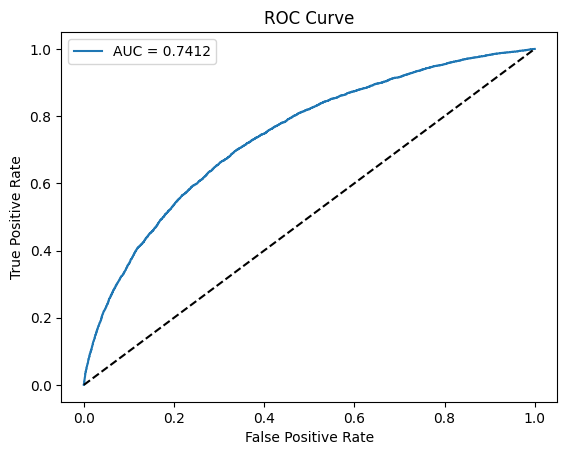

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

y_val_proba = sig_clf.predict_proba(X_val)[:, 1] 

fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Confusion Matrix & Metrics

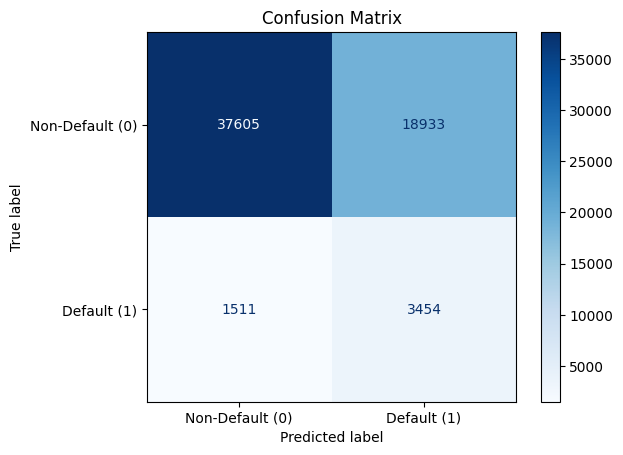

Best Threshold: 0.07704064353620603
G-Mean: 0.6802273911413659

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     56538
           1       0.15      0.70      0.25      4965

    accuracy                           0.67     61503
   macro avg       0.56      0.68      0.52     61503
weighted avg       0.90      0.67      0.74     61503



In [13]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    classification_report
)

gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)
best_threshold = thresholds[ix]

y_pred_gmean = (y_val_proba >= best_threshold).astype(int)
confusion_matrix(y_val, y_pred_gmean)


cm = confusion_matrix(y_val, y_pred_gmean)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Non-Default (0)", "Default (1)"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

print("Best Threshold:", best_threshold)
print("G-Mean:", gmeans[ix])

print("\nClassification Report:")
print(classification_report(y_val, y_pred_gmean))

### Analysis:
* **Recall**: The model catches around 67% of defaults, this represents a good value because, for this task, missing a default (False Negative) is worse than rejecting a good client (False Positive). Models aims is to reduce False Negative (high Recall).
* **Precision**: The model catches around 16% of precision. However this is expected due to imbalanced dataset, so many cases the precision for imbalanced tasks is not considered.
* **Threshold**: The best threshold found was 0.0115, and G-mean gotten was 0.679.

# Evaluate Test Dataset and Create Submission

Finally, we will re-train the model, but now with whole training dataset and predict `y_test` to create the submission.

In [14]:
X_train, X_test, y_train = Xtrain, Xtest, ytrain
best_clf.fit(X_train, y_train)  
sig_clf.fit(X_train, y_train)

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


CalibratedClassifierCV(estimator=Pipeline(steps=[('preprocess',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   StandardScaler(),
                                                                                   Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLA...
                                                                                                 handle_unknown='ignore'),
                                                                                   Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object'))])),
                                                 ('model',
                                                  SGDClassifier(alpha=0.01,
                                                                class_weight='balanced'))]))

In [15]:
from sklearn.metrics import roc_auc_score

y_train_proba = sig_clf.predict_proba(X_train)[:, 1]

train_auc = roc_auc_score(y_train, y_train_proba)
print(f"Train AUC: {train_auc:.4f}")

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Train AUC: 0.7441


In [16]:
ytest = sig_clf.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    'SK_ID_CURR': df_test['SK_ID_CURR'],
    'TARGET': ytest
})

s3_file_path = 's3://crisk-nico-prod/predictions/submissions/submission_svm_sgd.csv'

submission.to_csv(s3_file_path, index=False)

# Model Summary

**Model Type**

* LinearSVM implemented via SGD.
* Focuses on maximizing margin.
* Only points near the decision boundary matter (support vectors).

**Performance**

* Train AUC around 74.41%
* Test AUC around 72.93% (Based on Kaggle score).
* No overfitting
* Good recall of defaults around 70%

**Interpretability**

* Even though SVM is linear, it still has some weaknesses:
    * No coefficient-based odds ratios
    * Margins are harder to interpret

**Strengths**

* Robust to outliers due to margin
* SGD version scales to large datasets
* Good recall after threshold tuning
* Linear model is moderately interpretable via weights
* Calibrated probabilities work fine

**Weaknesses**

* SVM is not naturally probabilistic
* Harder to interpret than logistic regression
* Sensitive to scaling
* Can struggle with heavy overlapping distributions
* Noisy in high-dimensional sparse features
* Not regulatory friendly compared to logistic regression